In [22]:
# ============================================================
# Import required libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

In [23]:
# ============================================================
# Function: Load data from CSV files
# ============================================================
def load_data():
    # Read training, test, and sample submission datasets
    train = pd.read_csv("input/train.csv")
    test = pd.read_csv("input/test.csv")
    sample_submission = pd.read_csv("input/sample_submission.csv")

    # Return all three datasets
    return train, test, sample_submission

train, test, sample = load_data()
print(train.head())

   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

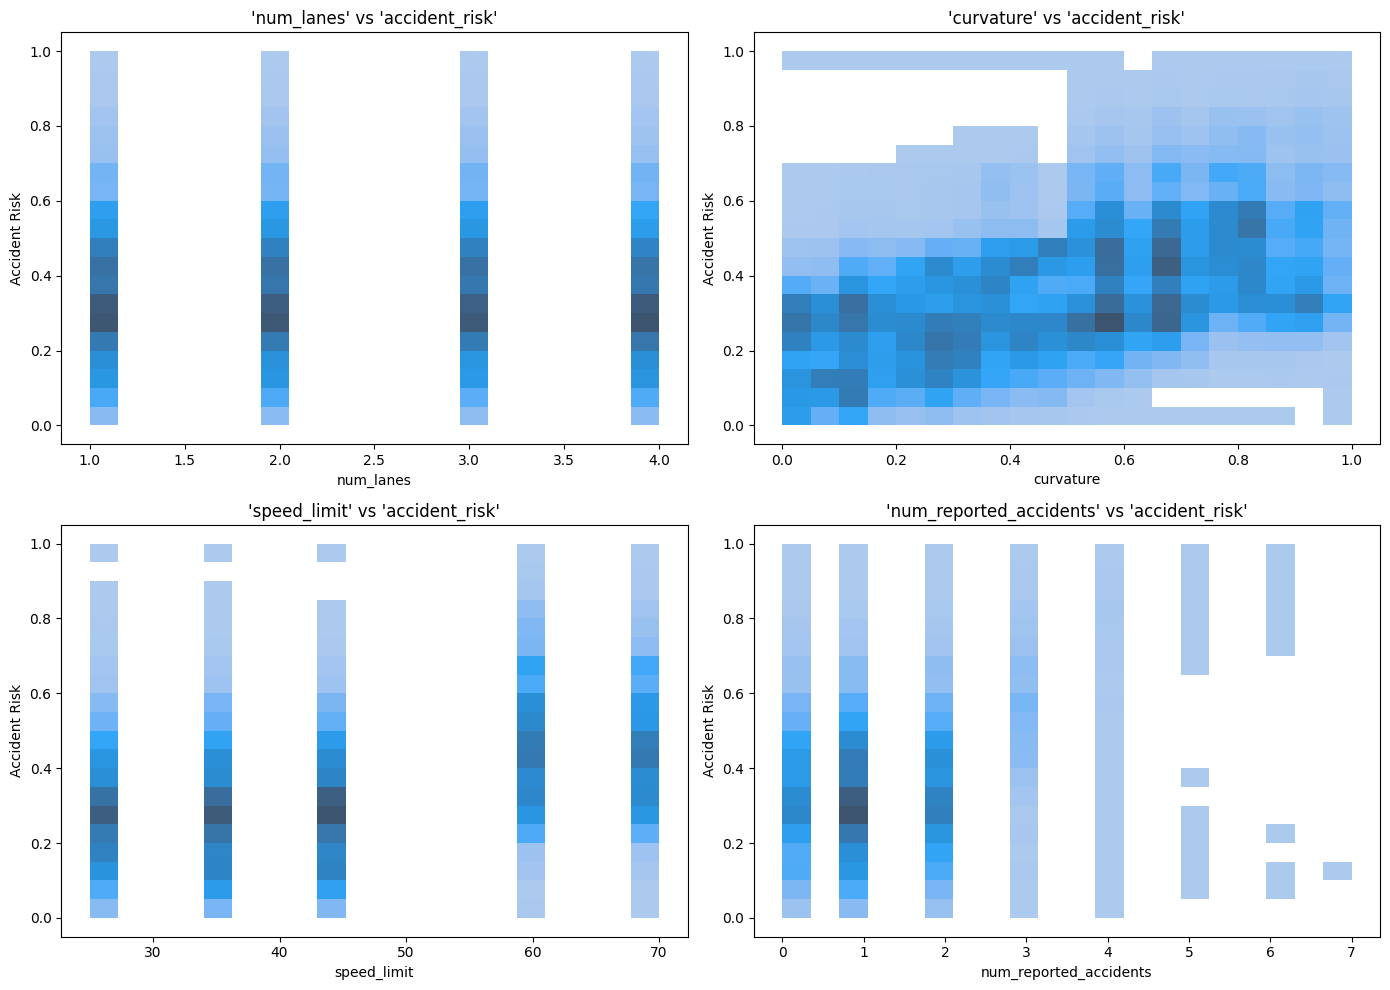

In [24]:
data, _ ,_ = load_data()

# Set up subplots for comparison
features = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(features):
    row, col = divmod(i, 2)

    # Create histogram
    sns.histplot(x=data[feature], y=data["accident_risk"], bins=20, ax=axes[row][col], kde=False)

    # Add title and labels
    axes[row][col].set_title(f"'{feature}' vs 'accident_risk'")
    axes[row][col].set_xlabel(feature)
    axes[row][col].set_ylabel("Accident Risk")

plt.tight_layout()
plt.show()

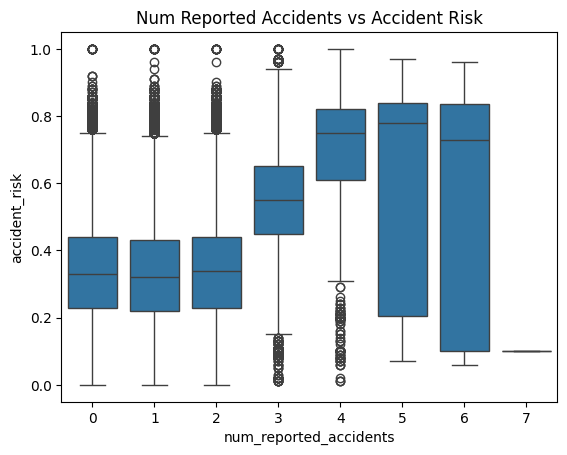

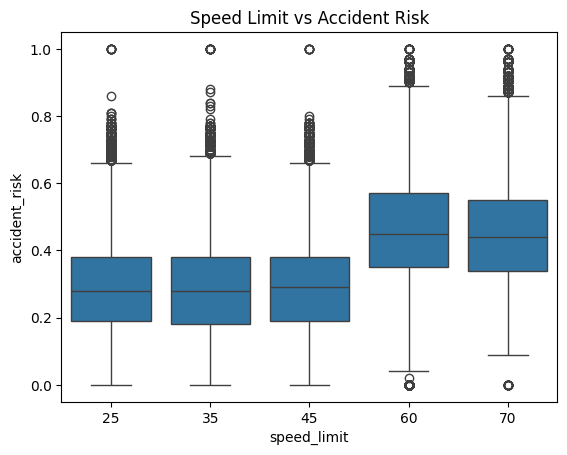

In [6]:

# Box plot for num_reported_accidents vs. accident_risk
sns.boxplot(data=data, x='num_reported_accidents', y='accident_risk')
plt.title("Num Reported Accidents vs Accident Risk")
plt.show()

# Box plot for speed_limit vs. accident_risk
sns.boxplot(data=data, x='speed_limit', y='accident_risk')
plt.title("Speed Limit vs Accident Risk")
plt.show()

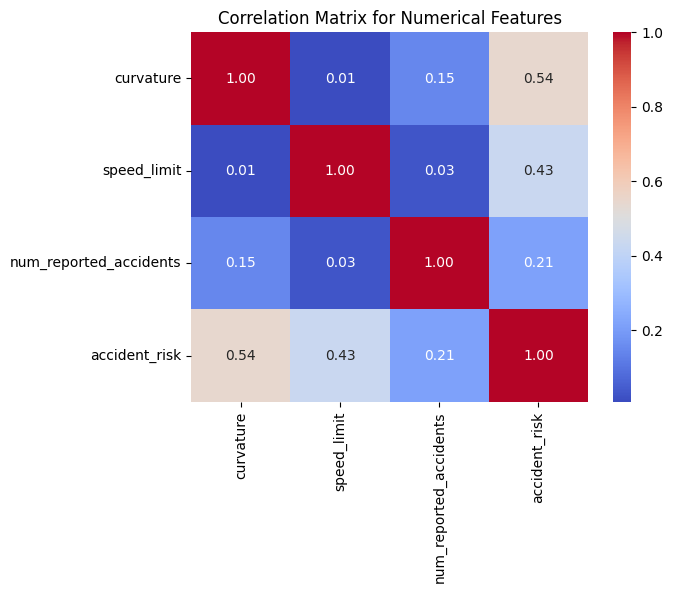

In [7]:
# Compute the correlation matrix
num_features = ['curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']
corr_matrix = data[num_features].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

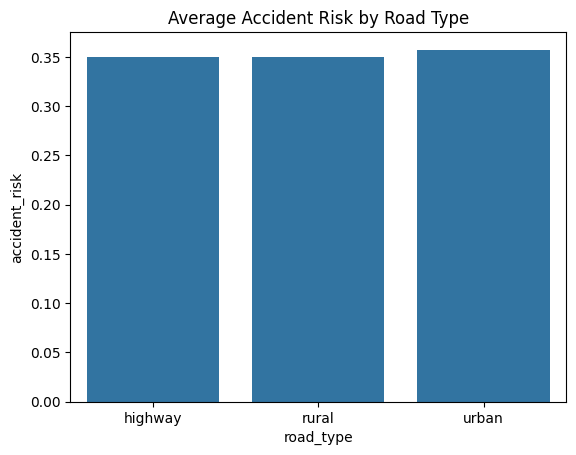

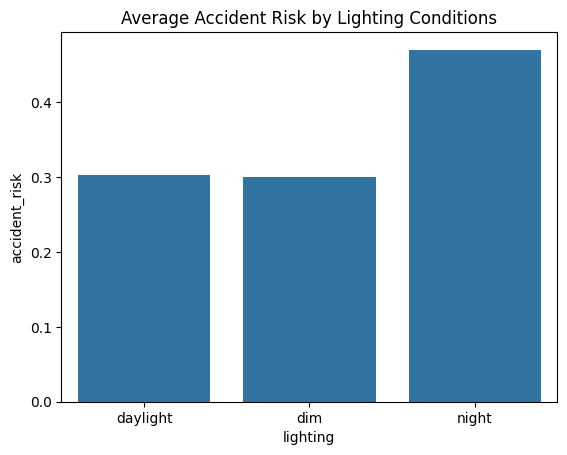

In [9]:
# Bar plot for road_type vs average accident_risk
avg_risk_by_road = data.groupby('road_type')['accident_risk'].mean().reset_index()
sns.barplot(x='road_type', y='accident_risk', data=avg_risk_by_road)
plt.title("Average Accident Risk by Road Type")
plt.show()

# Lighting vs Accident Risk
avg_risk_by_lighting = data.groupby('lighting')['accident_risk'].mean().reset_index()
sns.barplot(x='lighting', y='accident_risk', data=avg_risk_by_lighting)
plt.title("Average Accident Risk by Lighting Conditions")
plt.show()

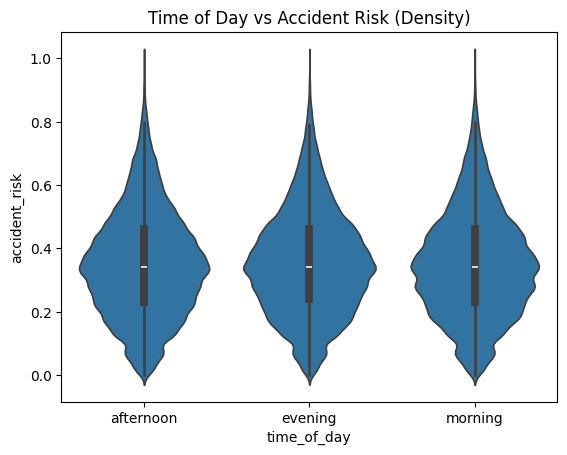

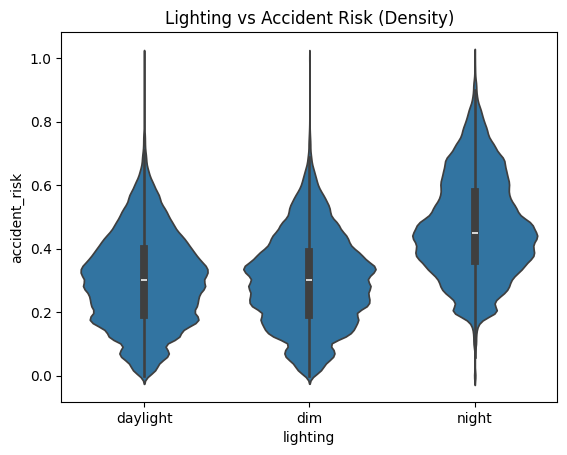

In [10]:
# Violin Plot for Time of Day vs Accident Risk
sns.violinplot(data=data, x='time_of_day', y='accident_risk')
plt.title("Time of Day vs Accident Risk (Density)")
plt.show()

# Violin Plot for Lighting vs Accident Risk
sns.violinplot(data=data, x='lighting', y='accident_risk')
plt.title("Lighting vs Accident Risk (Density)")
plt.show()

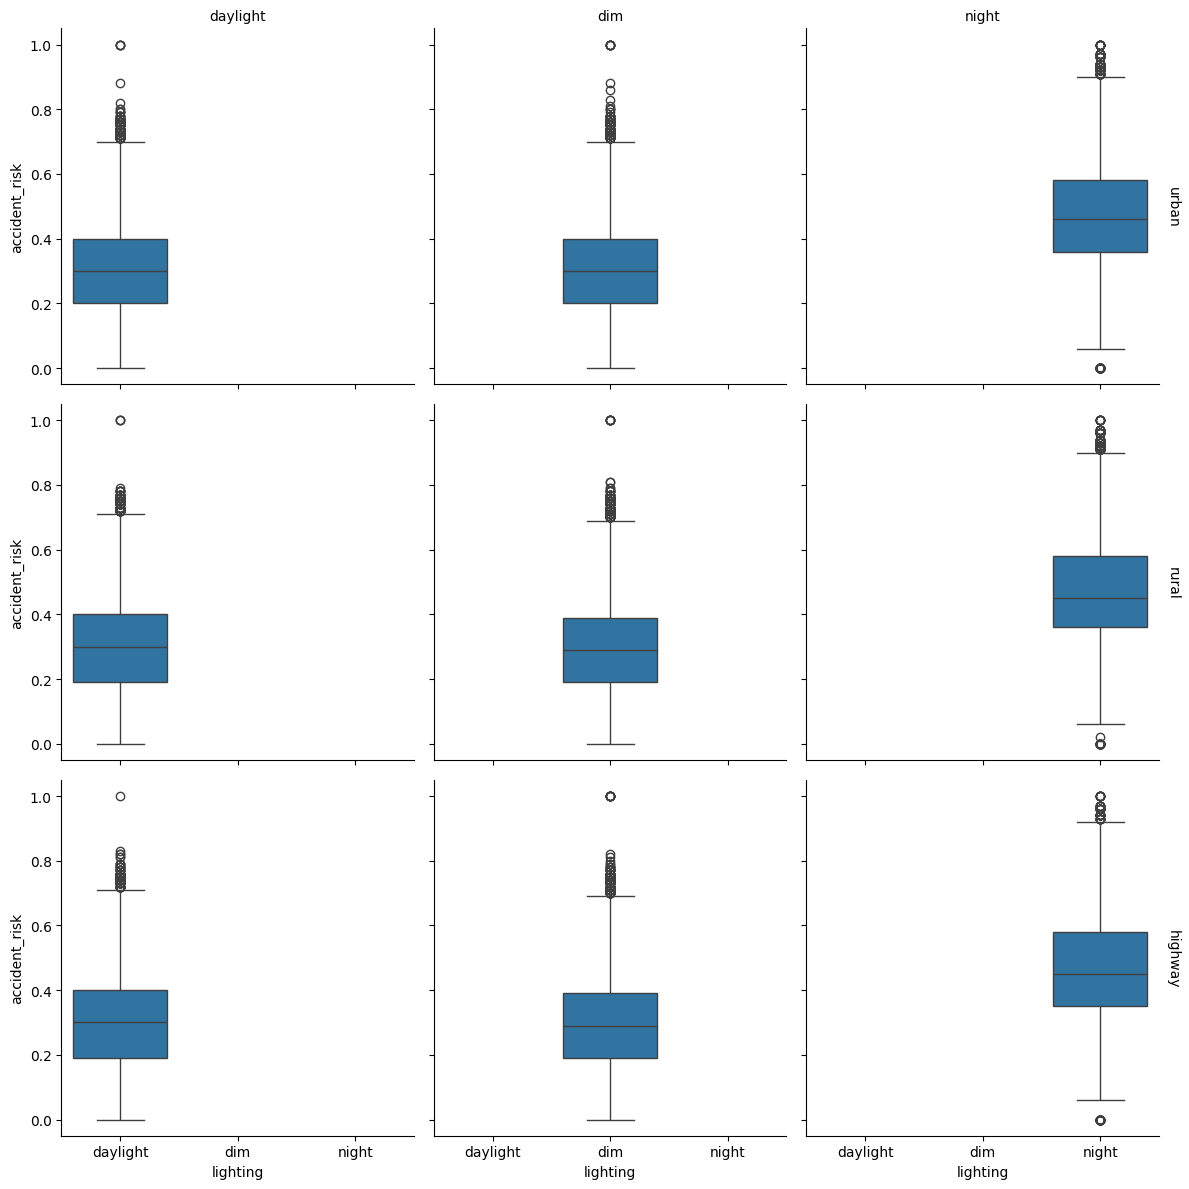

In [14]:
# FacetGrid: Accident Risk by road_type and lighting conditions
g = sns.FacetGrid(data, row='road_type', col='lighting', margin_titles=True, height=4, sharey=True)
g.map_dataframe(sns.boxplot, x='lighting', y='accident_risk')
g.set_titles(row_template="{row_name}", col_template="{col_name}")
plt.show()

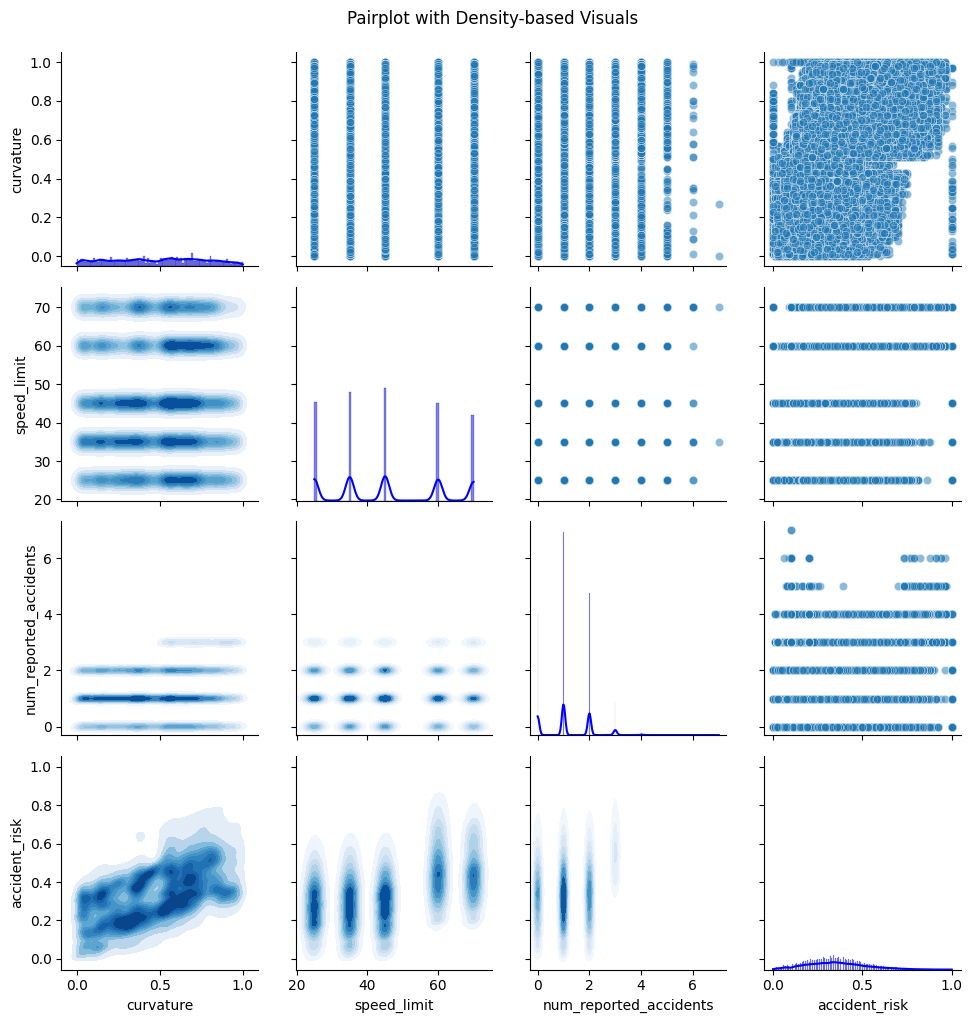

In [17]:
# Use PairGrid to fine-tune
g = sns.PairGrid(data, vars=["curvature", "speed_limit", "num_reported_accidents", "accident_risk"])

# Upper triangle: Scatter plot
g.map_upper(sns.scatterplot, alpha=0.5)

# Lower triangle: Kernel Density Plot
g.map_lower(sns.kdeplot, cmap='Blues', fill=True)

# Diagonal: Add 1D density (KDE or histogram)
g.map_diag(sns.histplot, kde=True, color='blue')

plt.suptitle("Pairplot with Density-based Visuals", y=1.02)
plt.show()

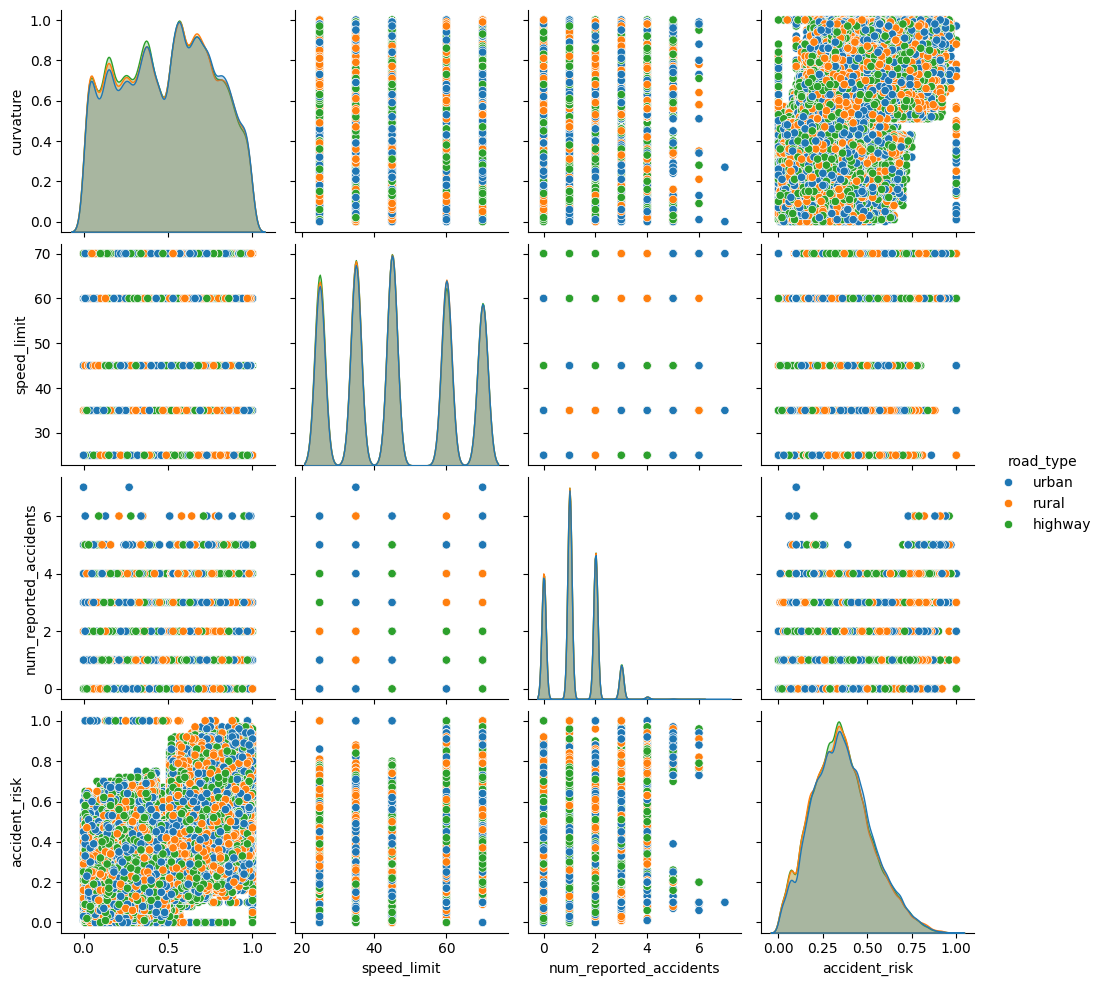

In [15]:
sns.pairplot(data, vars=['curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk'], hue='road_type')
plt.show()

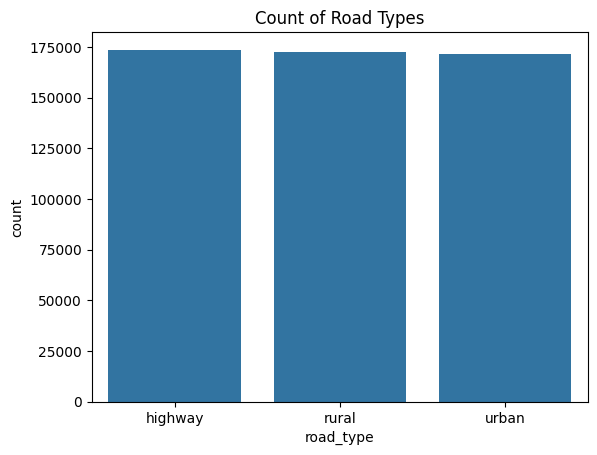

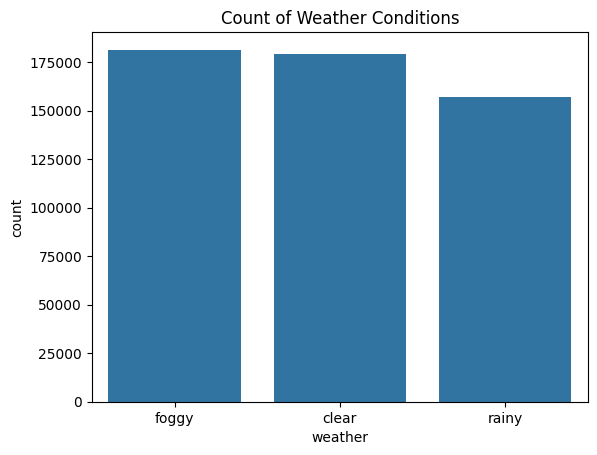

In [16]:
# Count plot: Road Type
sns.countplot(data=data, x='road_type', order=data['road_type'].value_counts().index)
plt.title("Count of Road Types")
plt.show()

# Count plot: Weather Conditions
sns.countplot(data=data, x='weather', order=data['weather'].value_counts().index)
plt.title("Count of Weather Conditions")
plt.show()

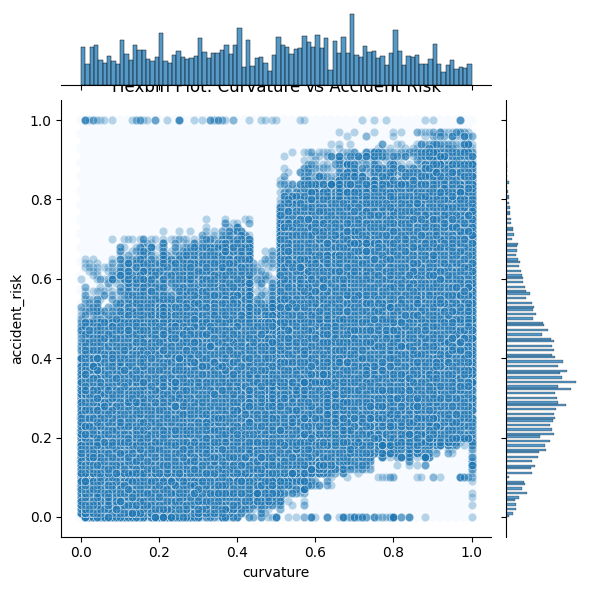

In [18]:
# Pairwise relationships using hexbin
sns.jointplot(
    data=data, x="curvature", y="accident_risk", kind="hex", cmap="Blues"
).plot_joint(sns.scatterplot, alpha=0.3)

plt.title("Hexbin Plot: Curvature vs Accident Risk")
plt.show()

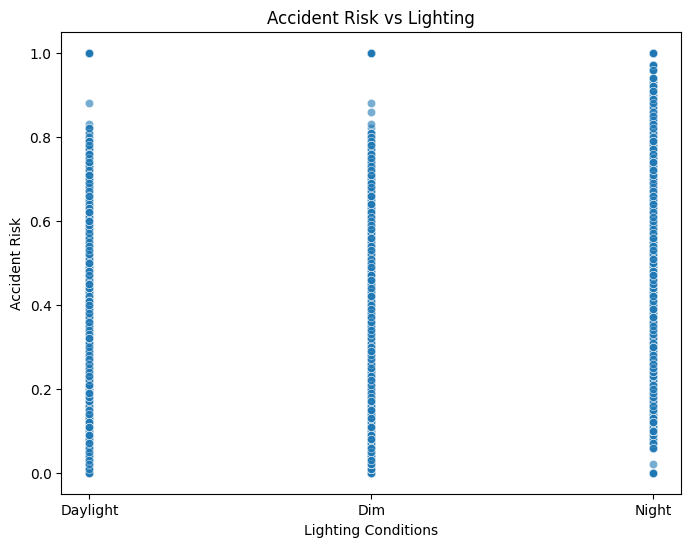

C:\Users\tebje\AppData\Local\Temp\ipykernel_28196\1197091677.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="lighting", y="accident_risk", data=avg_risk_by_lighting, palette="viridis")


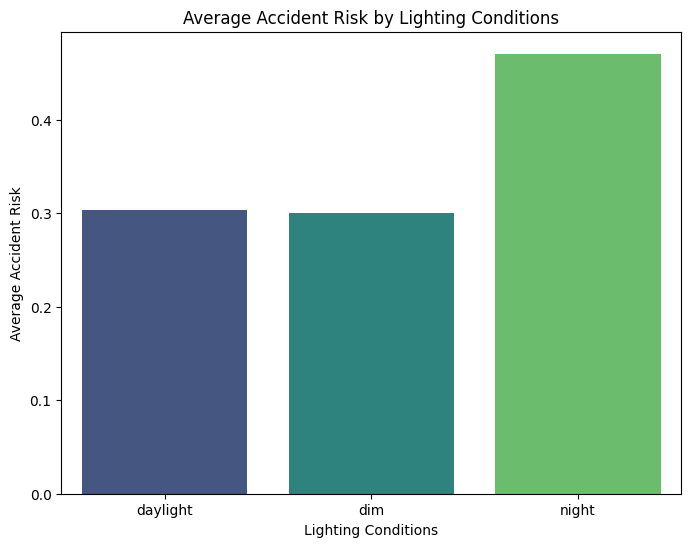

In [21]:
# Numerate Lighting Conditions
lighting_mapping = {"daylight": 1, "dim": 2, "night": 3}  # Mapping for lighting
data["lighting_numeric"] = data["lighting"].map(lighting_mapping)

# Scatter Plot: Lighting vs. Accident Risk (Numerical Axis)
plt.figure(figsize=(8, 6))
sns.scatterplot(x="lighting_numeric", y="accident_risk", data=data, alpha=0.6)
plt.xticks(ticks=[1, 2, 3], labels=["Daylight", "Dim", "Night"])  # Relabel x-axis for clarity
plt.title("Accident Risk vs Lighting")
plt.xlabel("Lighting Conditions")
plt.ylabel("Accident Risk")
plt.show()

# Bar Plot: Average Accident Risk by Lighting (Categorical Axis)
avg_risk_by_lighting = data.groupby("lighting")["accident_risk"].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x="lighting", y="accident_risk", data=avg_risk_by_lighting, palette="viridis")
plt.title("Average Accident Risk by Lighting Conditions")
plt.xlabel("Lighting Conditions")
plt.ylabel("Average Accident Risk")
plt.show()

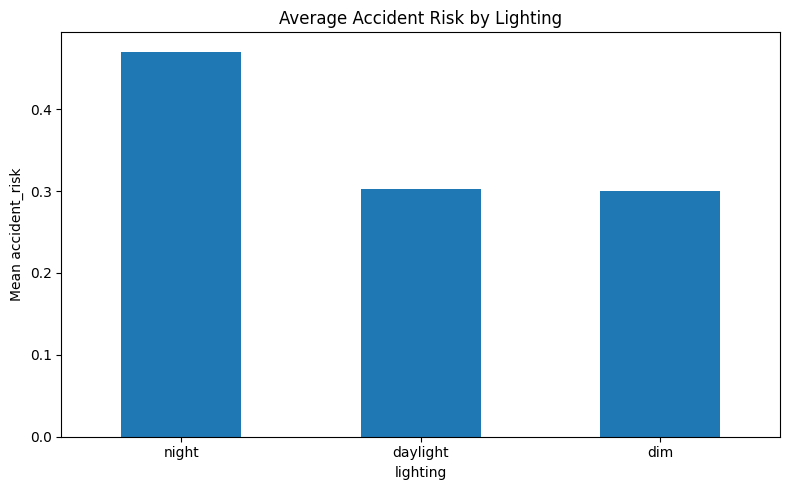

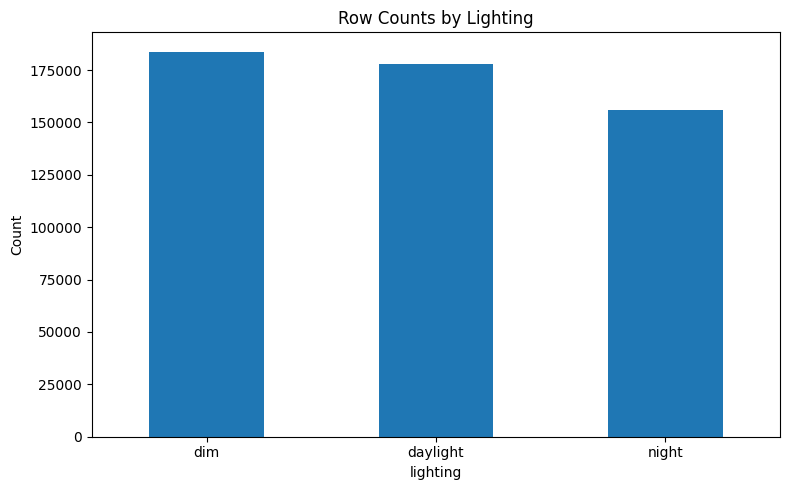

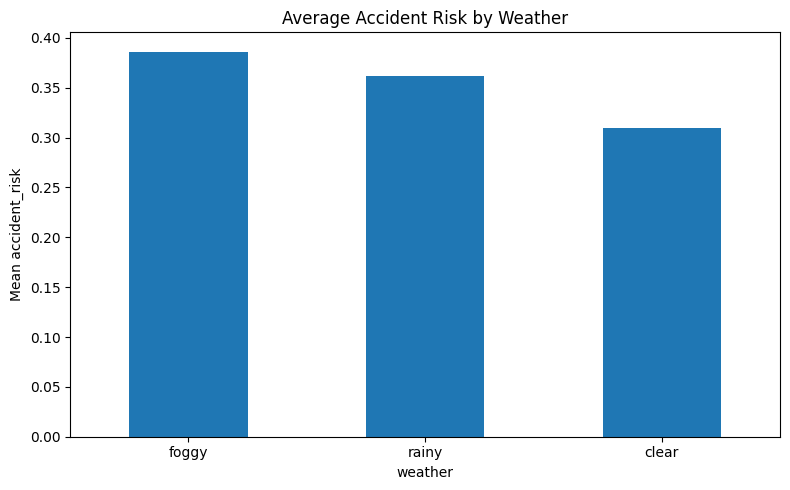

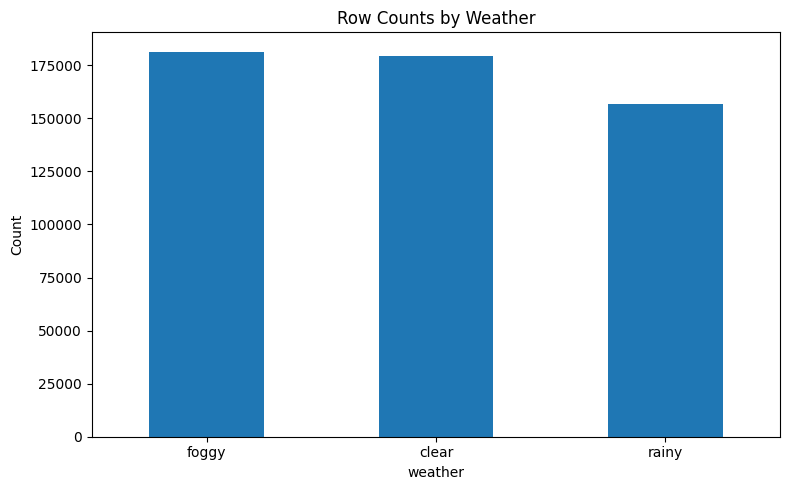

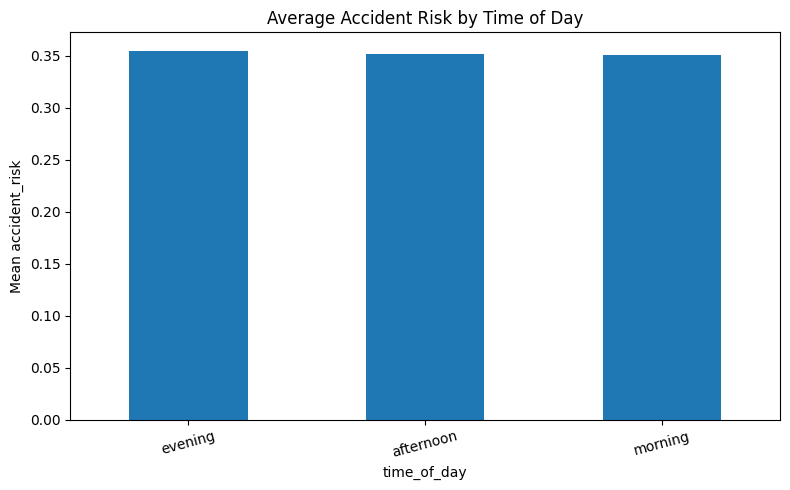

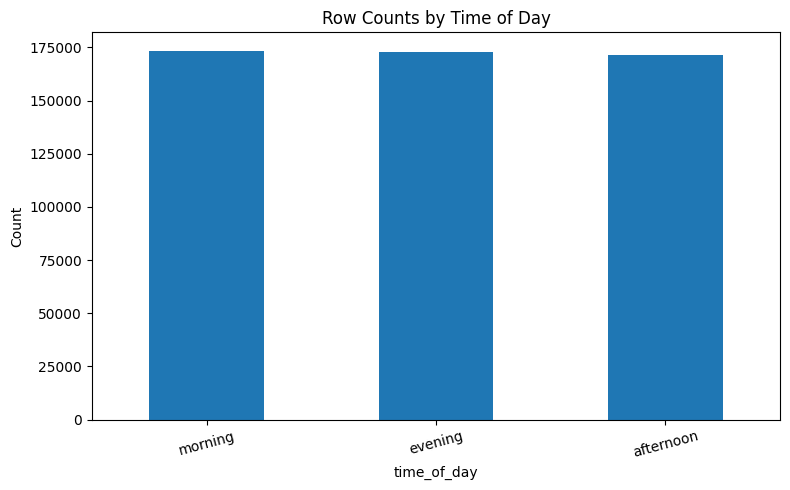

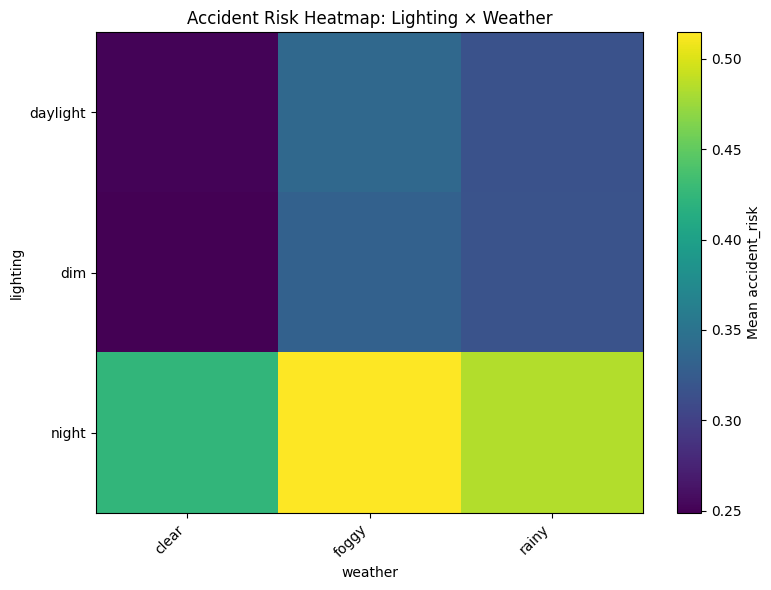

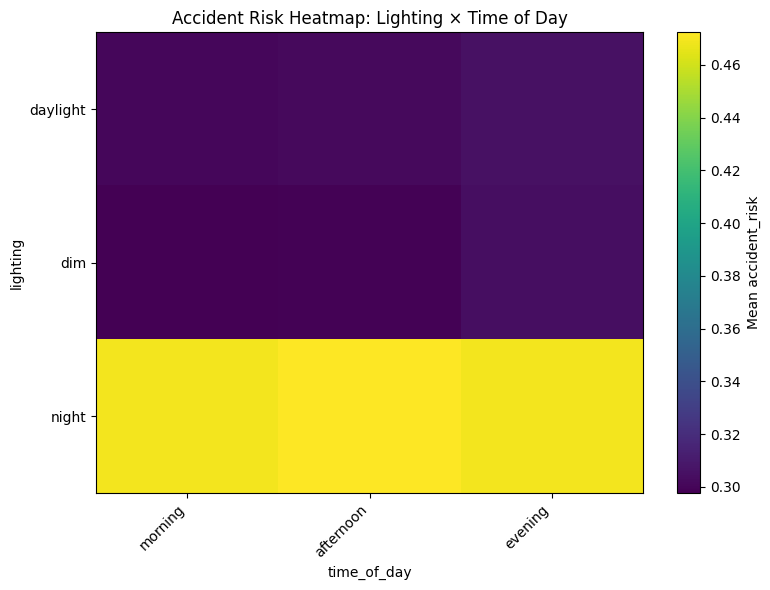

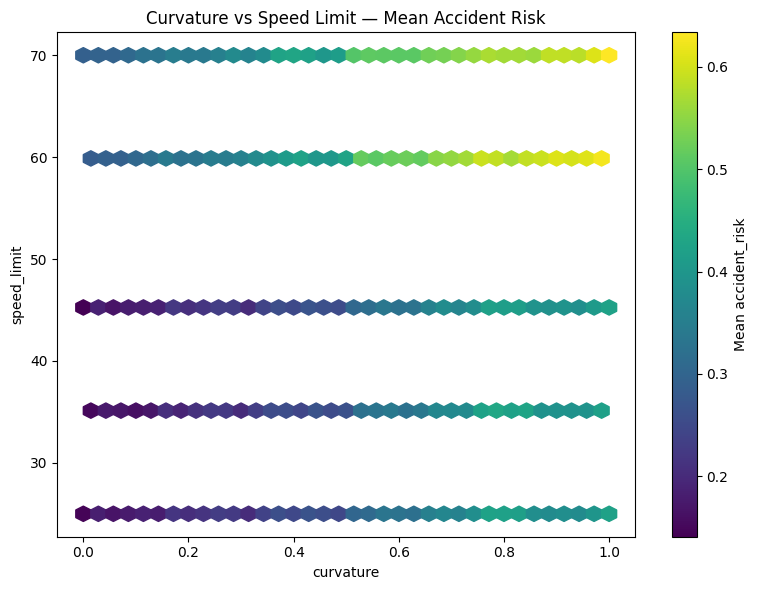

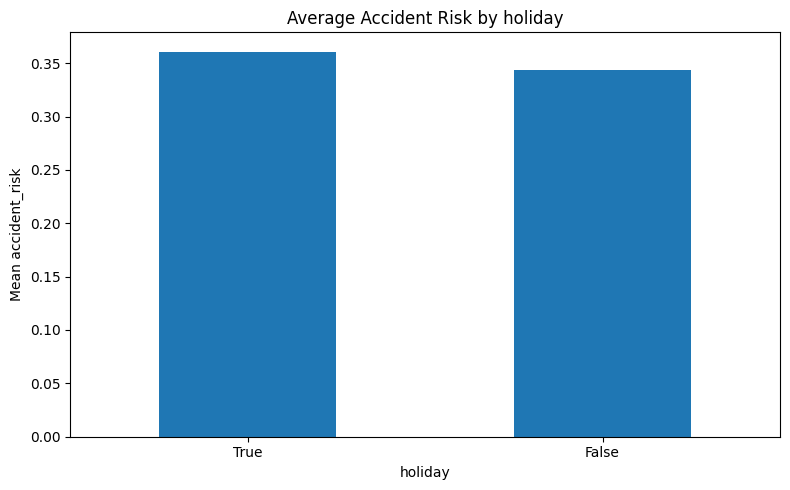

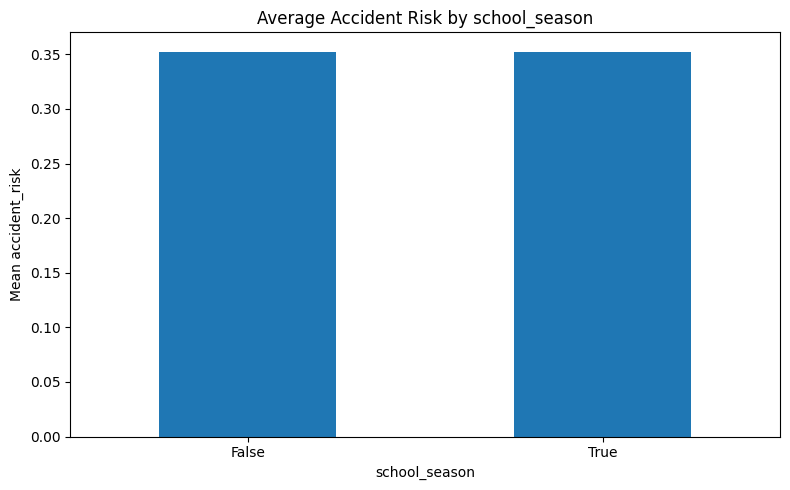

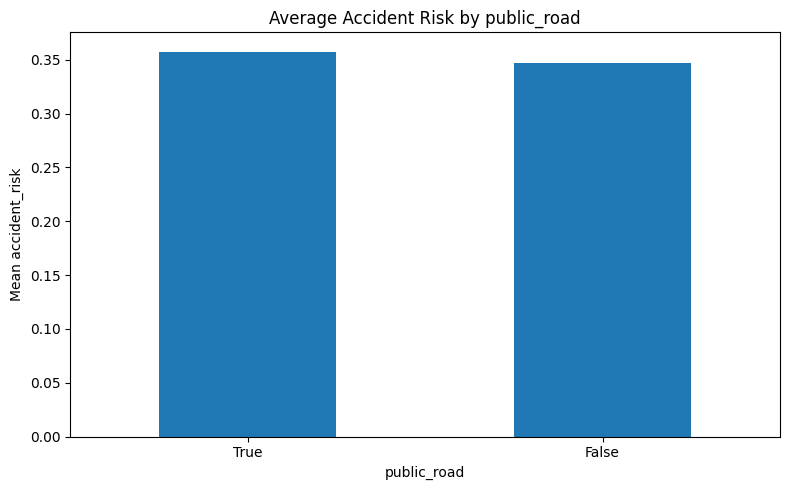

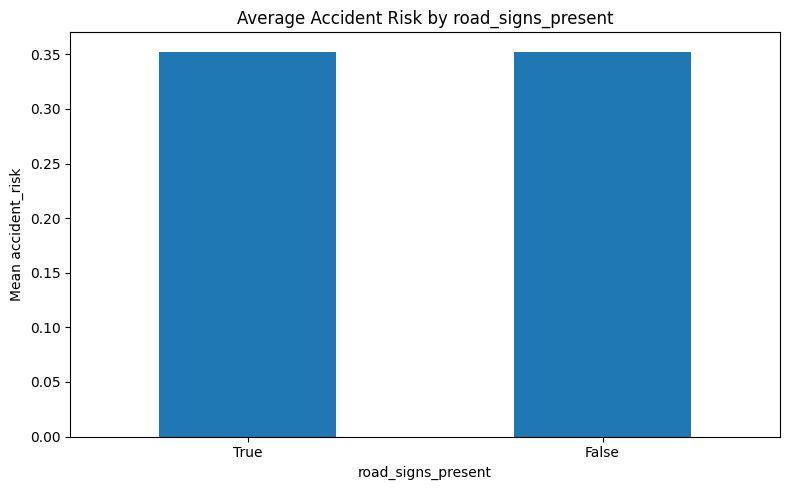

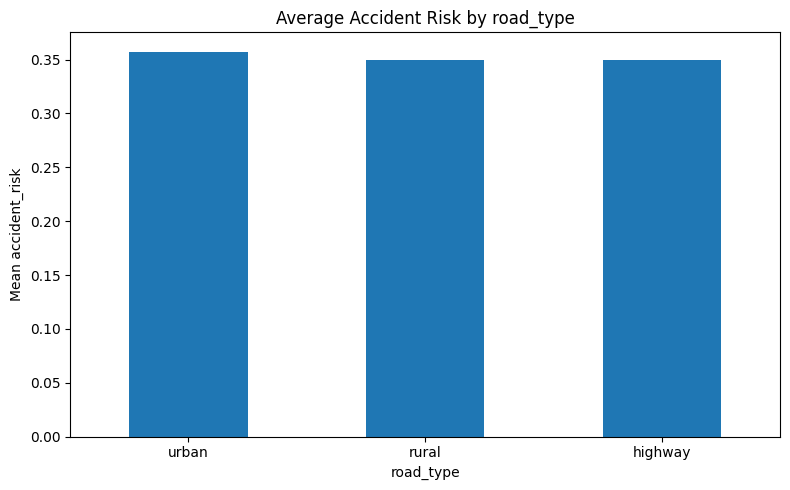

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Optional: enforce categoricals for efficiency and consistent ordering ---
cat_cols = ["lighting", "weather", "time_of_day", "road_type", "holiday", "school_season",
            "public_road", "road_signs_present"]
for c in cat_cols:
    if c in train.columns:
        train[c] = train[c].astype("category")

# Optional: set meaningful order for time_of_day if present
if "time_of_day" in train.columns:
    order = ["morning", "afternoon", "evening", "night"]
    existing = [x for x in order if x in train["time_of_day"].cat.categories]
    if existing:
        train["time_of_day"] = train["time_of_day"].cat.reorder_categories(existing, ordered=True)

# ----------------- Helpers -----------------

def bar_mean(df, by, target="accident_risk", title=None, rotation=0):
    """Bar chart of mean target by category (sorted by mean)."""
    agg = df.groupby(by, observed=True)[target].mean().sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    agg.plot(kind="bar")
    plt.ylabel(f"Mean {target}")
    plt.xlabel(by)
    plt.title(title or f"Mean {target} by {by}")
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

def bar_count(df, by, title=None, rotation=0):
    """Bar chart of counts by category."""
    cnt = df[by].value_counts(dropna=False)
    plt.figure(figsize=(8, 5))
    cnt.plot(kind="bar")
    plt.ylabel("Count")
    plt.xlabel(by)
    plt.title(title or f"Counts by {by}")
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

def heatmap_mean(df, index, columns, target="accident_risk", title=None):
    """Heatmap of mean target by two categorical dimensions."""
    pivot = pd.pivot_table(
        df,
        values=target,
        index=index,
        columns=columns,
        aggfunc="mean",
        observed=True
    )
    plt.figure(figsize=(8, 6))
    # imshow wants numeric; we fillna for display
    mat = pivot.values
    plt.imshow(mat, aspect="auto")
    plt.colorbar(label=f"Mean {target}")
    plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
    plt.title(title or f"{target} by {index} × {columns}")
    plt.xlabel(columns)
    plt.ylabel(index)
    plt.tight_layout()
    plt.show()

def hexbin_mean(df, x, y, c="accident_risk", gridsize=35, title=None):
    """Hexbin for large data: continuous x/y with color as mean target."""
    # Drop rows with missing values in used columns
    sub = df[[x, y, c]].dropna()
    plt.figure(figsize=(8, 6))
    hb = plt.hexbin(sub[x], sub[y], C=sub[c], gridsize=gridsize, reduce_C_function=np.mean)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"Hexbin mean {c}: {x} vs {y}")
    cb = plt.colorbar(hb)
    cb.set_label(f"Mean {c}")
    plt.tight_layout()
    plt.show()

# ----------------- Plots you probably want -----------------

# 1) Accident risk by lighting / weather / time_of_day (aggregated)
if "lighting" in train.columns:
    bar_mean(train, "lighting", target="accident_risk", title="Average Accident Risk by Lighting", rotation=0)
    bar_count(train, "lighting", title="Row Counts by Lighting", rotation=0)

if "weather" in train.columns:
    bar_mean(train, "weather", target="accident_risk", title="Average Accident Risk by Weather", rotation=0)
    bar_count(train, "weather", title="Row Counts by Weather", rotation=0)

if "time_of_day" in train.columns:
    bar_mean(train, "time_of_day", target="accident_risk", title="Average Accident Risk by Time of Day", rotation=15)
    bar_count(train, "time_of_day", title="Row Counts by Time of Day", rotation=15)

# 2) Combined effects (heatmaps): lighting × weather, lighting × time_of_day
if {"lighting", "weather"}.issubset(train.columns):
    heatmap_mean(train, "lighting", "weather", target="accident_risk",
                 title="Accident Risk Heatmap: Lighting × Weather")

if {"lighting", "time_of_day"}.issubset(train.columns):
    heatmap_mean(train, "lighting", "time_of_day", target="accident_risk",
                 title="Accident Risk Heatmap: Lighting × Time of Day")

# 3) If you have continuous features: curvature vs speed_limit colored by mean risk (big-data friendly)
if {"curvature", "speed_limit", "accident_risk"}.issubset(train.columns):
    hexbin_mean(train, x="curvature", y="speed_limit", c="accident_risk",
                title="Curvature vs Speed Limit — Mean Accident Risk")

# 4) Optional: show how holiday/school season/public road relate to risk (binary/categorical)
for col in ["holiday", "school_season", "public_road", "road_signs_present", "road_type"]:
    if col in train.columns:
        bar_mean(train, col, target="accident_risk", title=f"Average Accident Risk by {col}", rotation=0)
